<a href="https://colab.research.google.com/github/tevrat-aksoy/YOLO_Object_Counter/blob/main/YoloV4_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

YoloV4  Example
===


## Install `tf2_yolov4` + TensorFlow

In [6]:
!pip install --no-cache-dir https://github.com/sicara/tf2-yolov4/archive/master.zip
!pip install tensorflow

     | 3.0MB 1.8MB/s
  Created wheel for tf2-yolov4: filename=tf2_yolov4-0.1.0-cp37-none-any.whl size=20157 sha256=b02716893dbb6c08af2607fc081eef1b7ed5fce70c23087476a1b040f8fe760d
  Stored in directory: /tmp/pip-ephem-wheel-cache-lr2v7inh/wheels/dd/5a/79/53f47cadc4652a9a54ebe232fe724de8fdb8700e3a0c99bf9c
Successfully built tf2-yolov4


## Get COCO pretrained weights

First, download `yolov4.weights` from [AlexeyAB/darknet](https://github.com/AlexeyAB/darknet#how-to-evaluate-ap-of-yolov4-on-the-ms-coco-evaluation-server) repository.
The `yolov4.weights` file length should be `257717640`. If not, rerun the cell.

In [7]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1cewMfusmPjYWbrnuJRuKhPMwRe_b9PaT' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1cewMfusmPjYWbrnuJRuKhPMwRe_b9PaT" -O yolov4.weights
!rm -rf /tmp/cookies.txt
!ls -la ./yolov4.weights

--2021-07-15 12:50:54--  https://docs.google.com/uc?export=download&confirm=6Dwu&id=1cewMfusmPjYWbrnuJRuKhPMwRe_b9PaT
Resolving docs.google.com (docs.google.com)... 172.217.219.138, 172.217.219.100, 172.217.219.113, ...
Connecting to docs.google.com (docs.google.com)|172.217.219.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-1o-docs.googleusercontent.com/docs/securesc/cb7p7jao93fbcacfn2c5ltvo2otriitc/qif556obin1efkpfoq117emrba3fa462/1626353400000/14889149095783116612/06782135513388275025Z/1cewMfusmPjYWbrnuJRuKhPMwRe_b9PaT?e=download [following]
--2021-07-15 12:50:54--  https://doc-14-1o-docs.googleusercontent.com/docs/securesc/cb7p7jao93fbcacfn2c5ltvo2otriitc/qif556obin1efkpfoq117emrba3fa462/1626353400000/14889149095783116612/06782135513388275025Z/1cewMfusmPjYWbrnuJRuKhPMwRe_b9PaT?e=download
Resolving doc-14-1o-docs.googleusercontent.com (doc-14-1o-docs.googleusercontent.com)... 173.194.74.132, 2607:f8b0:4001:c0d::84
Connec

`tf2_yolov4` provides a `convert-darknet-weights`, a script to convert a darknet weights file (*.weights) to a tensorflow weights file (*.h5):

In [8]:
!convert-darknet-weights yolov4.weights -o yolov4.h5
!ls -la ./yolov4.h5

2021-07-15 12:50:57.562541: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-15 12:50:59.558546: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-15 12:50:59.658068: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-07-15 12:50:59.658141: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (51cd2ab05c5b): /proc/driver/nvidia/version does not exist
Download original Darknet weights
245432320/261095424 [===========================>..] - ETA: 0sConverting original Darknet weights to .h5 format
2021-07-15 12:51:09.144955: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-15 12:51:09.149423: I tensorflow/core/

## Read an image file

Import tensorflow, tf2_yolov4 model and anchors

In [9]:
import tensorflow as tf
from tf2_yolov4.anchors import YOLOV4_ANCHORS
from tf2_yolov4.model import YOLOv4
import cv2
import matplotlib.pyplot as plt
import os

from pathlib import Path
from numpy import loadtxt
import numpy as np
from google.colab.patches import cv2_imshow

Download an image:

In [10]:
!wget https://images.news18.com/ibnlive/uploads/2020/01/NEON-Artificial-Humans-3.png
from IPython.display import Image

--2021-07-15 12:51:17--  https://images.news18.com/ibnlive/uploads/2020/01/NEON-Artificial-Humans-3.png
Resolving images.news18.com (images.news18.com)... 23.35.69.42, 23.35.69.82, 2600:1407:21::17d7:68d3, ...
Connecting to images.news18.com (images.news18.com)|23.35.69.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50452 (49K) [image/jpeg]
Saving to: ‘NEON-Artificial-Humans-3.png’

NEON-Artificial-Hum 100%[===================>]  49.27K   190KB/s    in 0.3s    

2021-07-15 12:51:19 (190 KB/s) - ‘NEON-Artificial-Humans-3.png’ saved [50452/50452]



In [11]:
# COCO classes
CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
    'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = loadtxt("/content/colors.txt").tolist()  # box colors


 Define helper functions

In [12]:

def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)
  
  return name

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

In [13]:
def detected_image(img, boxes, scores, classes):
  
    """
        Draws the class boxes with their scores on a OpenCV image
        Arguments:
            img -- image opened with OpenCV
            boxes -- the list of boxes(their coordinates)
            scores -- the list of scores for each box
            classes -- the list of classes for each box
        Returns:
            img -- processed image with all the boxes drawn

    """
    counter_obj=np.zeros([80])

    for (xmin, ymin, xmax, ymax), score, cl in zip(boxes.tolist(), scores.tolist(), classes.tolist()):


        if score > 0:
            start_point = (int(xmin), int(ymin))
            end_point = (int(xmax), int(ymax))
            color=COLORS[cl % 6]
            img = cv2.rectangle(img, start_point, end_point, color, 2)  # draw class box
            text = f'{CLASSES[cl]}: {score:0.2f}'
            counter_obj[cl]=counter_obj[cl]+1

            (test_width, text_height), baseline = cv2.getTextSize(text, cv2.FONT_ITALIC, 0.5, 1)
            end_point = (int(xmin) + test_width + 2, int(ymin) - text_height - 2)
            img = cv2.rectangle(img, start_point, end_point, color, -1)
            cv2.putText(img, text, start_point, cv2.FONT_ITALIC, 0.5, 0, 1)  # print class type with score

    detected_obj=0
    for i,c in zip(range(80), counter_obj) :
      if c>0:
        detected_obj=detected_obj+1

        text2= str(CLASSES[int(i)])+" count "+ str(int(c)) 
        print(text2)
        cv2.putText(img, text2, (2,detected_obj*15+5) ,cv2.FONT_ITALIC, 0.5,(0,0,255) , 0, 1)
        


    return img

In [14]:
def processed_image(imgpath):
  img = cv2.imread(imgpath)
  
  image = tf.convert_to_tensor(img)
  image = tf.image.resize(image, (HEIGHT, WIDTH))
  image = tf.expand_dims(image, axis=0) / 255.0
  plt.axis("off")
  plt.imshow(image[0,:,:,::-1])
  plt.show()

  return image


In [17]:
imgtest = cv2.imread("/content/NEON-Artificial-Humans-3.png")

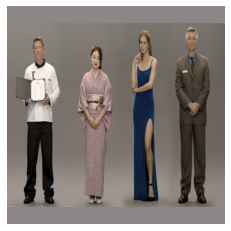

In [18]:
HEIGHT, WIDTH = 608,608
img=processed_image("/content/NEON-Artificial-Humans-3.png")

# Creating Model

In [19]:
model = YOLOv4(
    input_shape=(HEIGHT, WIDTH, 3),
    anchors=YOLOV4_ANCHORS,
    num_classes=80,
    training=False,
    
    yolo_max_boxes=100,
    yolo_iou_threshold=0.5,
    yolo_score_threshold=0.5,
)

model.load_weights("./yolov4.h5")
model.summary()

Model: "YOLOv4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 608, 608, 3) 0                                            
__________________________________________________________________________________________________
CSPDarknet53 (Functional)       [(None, 76, 76, 256) 26652512    input_8[0][0]                    
__________________________________________________________________________________________________
YOLOv4_neck (Functional)        [(None, 76, 76, 128) 15857152    CSPDarknet53[0][0]               
                                                                 CSPDarknet53[0][1]               
                                                                 CSPDarknet53[0][2]               
_____________________________________________________________________________________________

In [20]:
boxes, scores, classes, valid_detections = model.predict(img)

In [21]:
if os.path.isdir("/content/output_image") is False:
        os.mkdir("/content/output_image")

output_image_path = os.path.join("/content/output_image", Path("/DetectedImg.png").name)

# Image Prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


person count 4
tie count 1


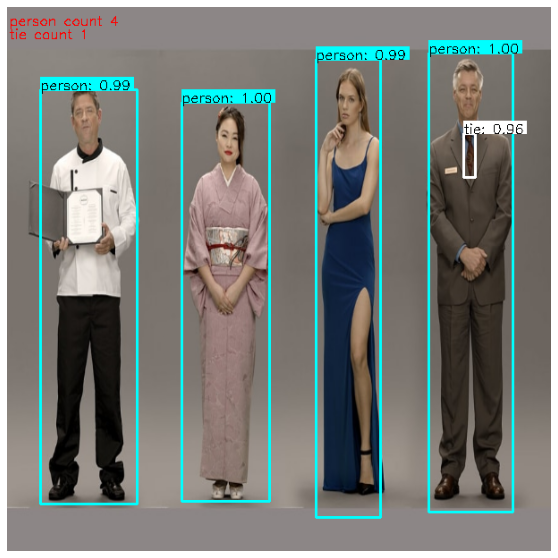

In [22]:
output_image=result_img = detected_image(img[0].numpy(), boxes[0] * [WIDTH, HEIGHT, WIDTH, HEIGHT], scores[0], classes[0].astype(int))

cv2.imwrite(output_image_path, result_img)
fig = plt.gcf()
fig.set_size_inches(18, 10)
plt.axis("off")
plt.imshow(output_image[:,:,::-1])

In [23]:
# Uploading a file
uploadedimg_path=upload()

Saving test.jpeg to test.jpeg
saved file test.jpeg


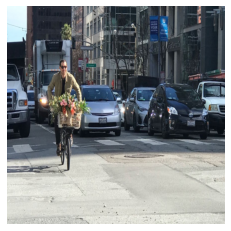

In [26]:
uploaded=processed_image("/content/"+uploadedimg_path)

In [27]:
if os.path.isdir("/content/output_image") is False:
        os.mkdir("/content/output_image")

output_image_path = os.path.join("/content/output_image/", Path(uploadedimg_path).name)

In [28]:
boxes, scores, classes, valid_detections = model.predict(uploaded)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


person count 1
bicycle count 1
car count 4
truck count 3


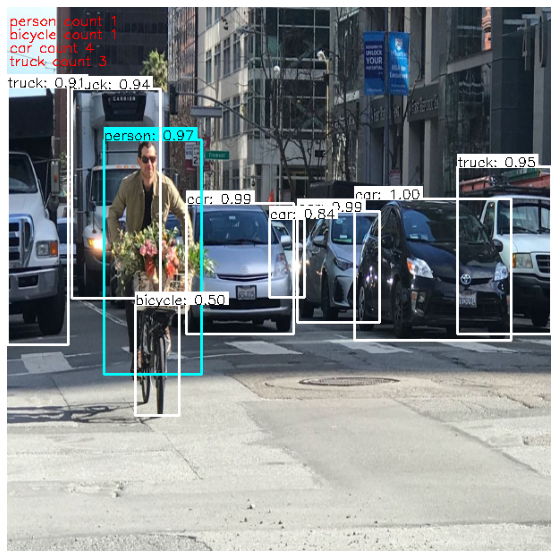

In [29]:
output_image = detected_image(uploaded[0].numpy(), boxes[0] * [WIDTH, HEIGHT, WIDTH, HEIGHT], scores[0], classes[0].astype(int))

cv2.imwrite(output_image_path, output_image)
fig = plt.gcf()
fig.set_size_inches(18, 10)
plt.axis("off")
plt.imshow(output_image[:,:,::-1])

Define video prediction function

In [41]:

def detect_video(video_path, output_path="output_videos"):
    """
        Detects the objects from a video using a YOLOv4 model and returns the result video with the same name
        Arguments:
            video_path -- path of the image to run detection on
            output_path -- the path of the output folder
        Returns:
            output_video_path -- path to processed video with all the boxes drawn
    """
    print("\nObject detection on " + Path(video_path).name)
    cap = cv2.VideoCapture(video_path)
    frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))


    yolo_model = YOLOv4(input_shape=(HEIGHT, WIDTH, 3), anchors=YOLOV4_ANCHORS, num_classes=80,
                        training=False, yolo_max_boxes=100, yolo_iou_threshold=0.5, yolo_score_threshold=0.5,
                        )
   
    yolo_model.load_weights("./yolov4.h5")
    
    yolo_model.summary()
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')

    out = cv2.VideoWriter(output_path, fourcc, int(cap.get(cv2.CAP_PROP_FPS)), (HEIGHT, WIDTH))
    while cap.isOpened():
        ret, frame = cap.read()
        if ret is True:
            image = tf.convert_to_tensor(frame)
            image = tf.image.resize(image, (HEIGHT, WIDTH))
            images = tf.expand_dims(image, axis=0) / 255.0
            boxes, scores, classes, valid_detections = yolo_model.predict(images)

            frame = detected_image(frame, boxes[0] * [WIDTH, HEIGHT, WIDTH, HEIGHT], scores[0], classes[0].astype(int))
            #cv2_imshow(Path(video_path).name, frame)
            out.write(frame)
            if cv2.waitKey(int(50 // cap.get(cv2.CAP_PROP_FPS))) & 0xFF == 27:  # 27 = ESC ASCII code
                break
        else:
            break
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    return output_path



# Video Prediction

In [42]:
videopath=upload()

UnboundLocalError: ignored

In [ ]:
if os.path.isdir("/content/output_videos") is False:
        os.mkdir("/content/output_videos")
detect_video(videopath, "/content/output_videos/"+videopath)


Object detection on testvideo.mp4
Model: "YOLOv4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_64 (InputLayer)           [(None, 608, 608, 3) 0                                            
__________________________________________________________________________________________________
CSPDarknet53 (Functional)       [(None, 76, 76, 256) 26652512    input_64[0][0]                   
__________________________________________________________________________________________________
YOLOv4_neck (Functional)        [(None, 76, 76, 128) 15857152    CSPDarknet53[0][0]               
                                                                 CSPDarknet53[0][1]               
                                                                 CSPDarknet53[0][2]               
__________________________________________________________